In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pydicom import dcmread
from pydicom.pixels import apply_voi_lut
import numpy as np
import cv2
sys.path.insert(0, '..')

from src.utils.image import crop_to_roi, get_final_image
from src.utils.normalization import truncate_normalization
import skimage as ski


data_dir = '/media/nvidia/DATA/Data/vindr_mammo/'
df_find = pd.read_csv(os.path.join(data_dir, 'finding_annotations.csv'))
sample_row = df_find.iloc[0]

In [7]:
def load_dicom_image(path: str):
    """Load a .dicom image file

    Args:
        path (str): Path to the dicom file

    Returns:
        np.array: Loaded image as np.array
    """
    ds = dcmread(path)
    img2d = ds.pixel_array
    img2d = apply_voi_lut(img2d, ds)

    if ds.PhotometricInterpretation == "MONOCHROME1":
        img2d = np.amax(img2d) - img2d

    return cv2.normalize(img2d, None, 0, 255, cv2.NORM_MINMAX)


sample_image_path = os.path.join(data_dir, 'images', sample_row['study_id'], sample_row['image_id'] + '.dicom')
original_image = load_dicom_image(sample_image_path)

In [8]:

cropped_image, mask = crop_to_roi(original_image)
normalized_image = truncate_normalization(cropped_image, mask)
final_image = get_final_image(sample_image_path, 512)

def plot_image_histogram(image, z_min = 0.1, z_max = 0.8):

    image = ski.util.img_as_float(image)

    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 1))

    histogram_percentage = (histogram / histogram.sum()) * 100

    _, ax = plt.subplots(1, 3, figsize=(15, 6))

    ax[0].imshow(image, cmap='gray')
    ax[0].axis('off')

    ax[1].bar(bin_edges[:-1], histogram_percentage, width=bin_edges[1] - bin_edges[0], color='orange')
    ax[1].set_title("Entire intensity histogram")
    ax[1].set_xlabel("Intensity Value")
    ax[1].set_ylabel("Percentage (%)")
    ax[1].set_xlim([-0.02, 1.0])

    zoomed_indices = (bin_edges[:-1] >= z_min) & (bin_edges[:-1] <= z_max)
    zoomed_bins = bin_edges[:-1][zoomed_indices]
    zoomed_values = histogram_percentage[zoomed_indices]

    ax[2].bar(zoomed_bins, zoomed_values, width=bin_edges[1] - bin_edges[0], color='orange',)
    ax[2].set_title("Zoomed histogram")
    ax[2].set_xlabel("Intensity Value")
    ax[2].set_ylabel("Percentage (%)")
    ax[2].set_xlim([z_min, z_max])
    ax[2].set_ylim([0, zoomed_values.max() * 1.1]) 

    plt.show()

/tmp/ipykernel_2976187/909309630.py:33: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[2].set_ylim([0, zoomed_values.max() * 1.1])


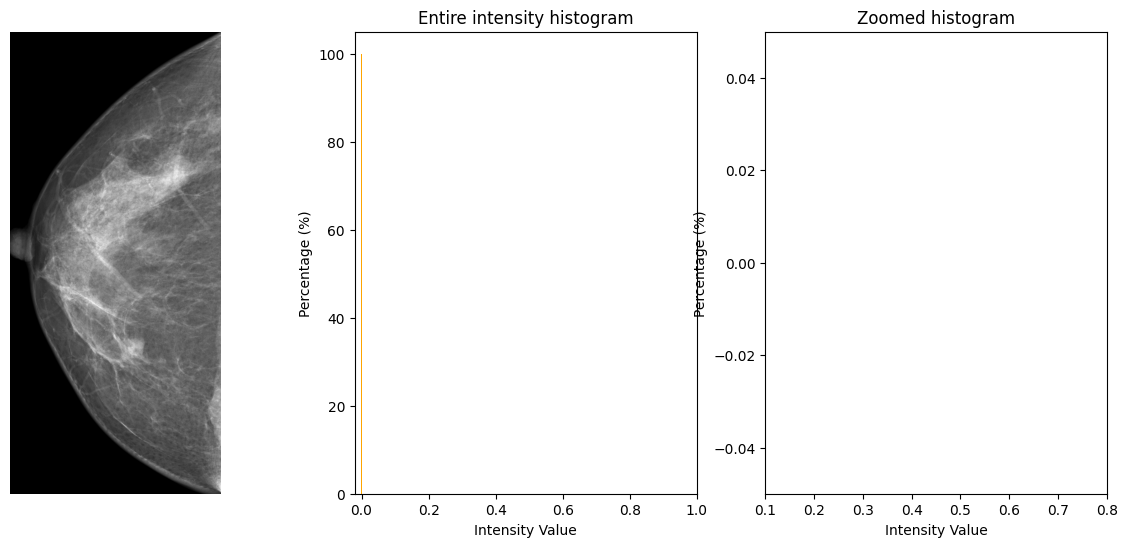

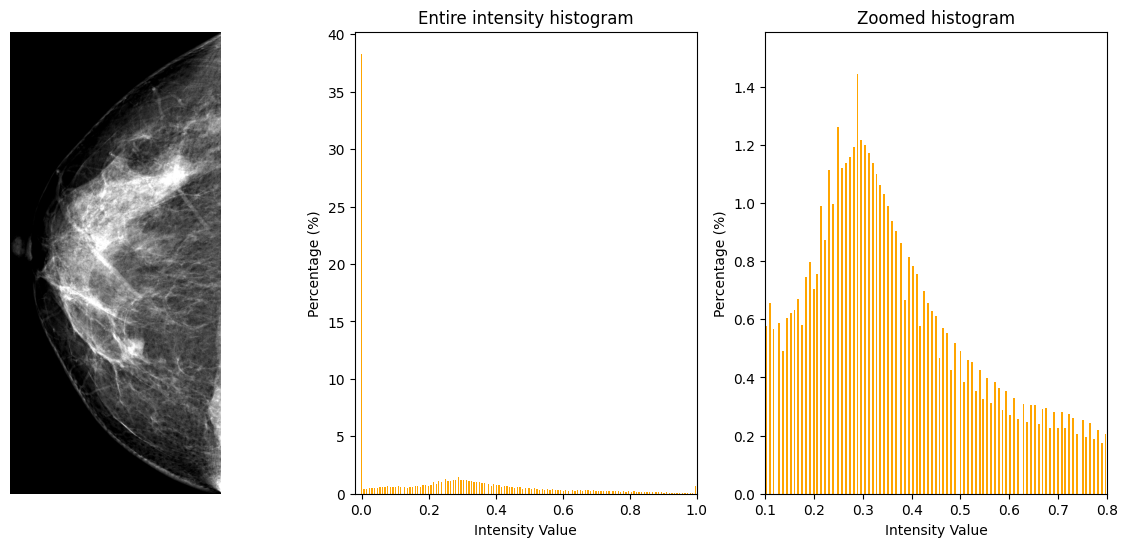

In [9]:
plot_image_histogram(cropped_image)
plot_image_histogram(normalized_image)